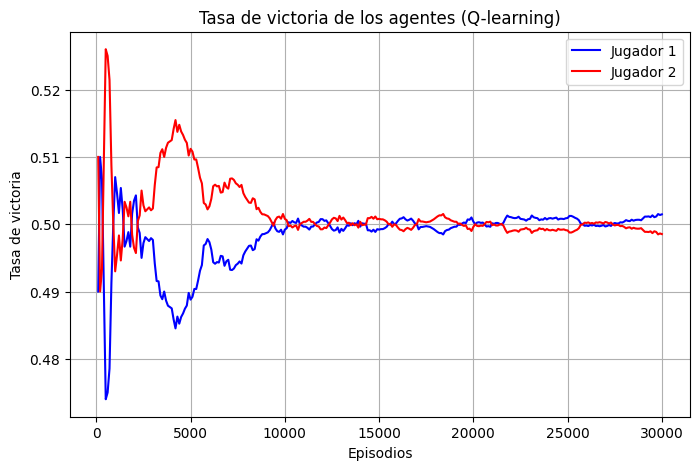

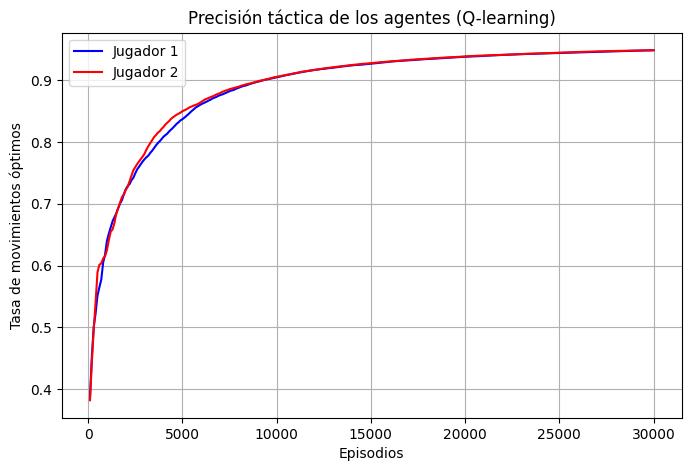

In [4]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# ----------------------------
# Parámetros del entorno
# ----------------------------
NUM_HEAPS = 3
MAX_HEAP_SIZE = 5
EPISODES = 30000
ALPHA = 0.2
GAMMA = 0.6
EPSILON_START = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99

# ----------------------------
# Funciones auxiliares
# ----------------------------
def get_possible_actions(state):
    actions = []
    for i, heap in enumerate(state):
        for amt in range(1, heap + 1):
            actions.append((i, amt))
    return actions

def apply_action(state, action):
    heap_idx, remove_amt = action
    state = list(state)
    state[heap_idx] -= remove_amt
    return tuple(state)

def is_terminal(state):
    return all(heap == 0 for heap in state)

def choose_action(state, Q, epsilon):
    actions = get_possible_actions(state)
    if not actions:
        return None
    if random.random() < epsilon:
        return random.choice(actions)
    q_vals = [Q[(state, a)] for a in actions]
    max_q = max(q_vals)
    best_actions = [a for a, q in zip(actions, q_vals) if q == max_q]
    return random.choice(best_actions)

def xor_sum(state):
    result = 0
    for heap in state:
        result ^= heap
    return result

# ----------------------------
# Inicialización de Q-learning
# ----------------------------
Q1 = defaultdict(float)
Q2 = defaultdict(float)
epsilon1 = EPSILON_START
epsilon2 = EPSILON_START

win_counts_1 = 0
win_counts_2 = 0
win_rates_1 = []
win_rates_2 = []

optimal_opportunities_1 = 0
optimal_moves_1 = 0
optimal_opportunities_2 = 0
optimal_moves_2 = 0
optimal_move_rate_1 = []
optimal_move_rate_2 = []

# ----------------------------
# Entrenamiento con Q-learning para dos agentes
# ----------------------------
for episode in range(EPISODES):
    state = tuple(random.randint(1, MAX_HEAP_SIZE) for _ in range(NUM_HEAPS))
    player_turn = random.randint(0, 1)

    prev_state = [None, None]
    prev_action = [None, None]

    while not is_terminal(state):
        Q = Q1 if player_turn == 0 else Q2
        epsilon = epsilon1 if player_turn == 0 else epsilon2

        actions = get_possible_actions(state)
        xor_before = xor_sum(state)
        good_move_available = any(xor_sum(apply_action(state, a)) == 0 for a in actions)

        if player_turn == 0:
            if xor_before != 0 and good_move_available:
                optimal_opportunities_1 += 1
        else:
            if xor_before != 0 and good_move_available:
                optimal_opportunities_2 += 1

        action = choose_action(state, Q, epsilon)
        if action is None:
            break
        next_state = apply_action(state, action)

        # Verificación de buen movimiento
        if player_turn == 0 and xor_before != 0 and xor_sum(next_state) == 0:
            optimal_moves_1 += 1
        if player_turn == 1 and xor_before != 0 and xor_sum(next_state) == 0:
            optimal_moves_2 += 1

        # Actualizar Q del jugador anterior si aplica
        if prev_state[player_turn] is not None and prev_action[player_turn] is not None:
            reward = 0
            next_actions = get_possible_actions(state)
            max_next_q = max([Q[(state, a)] for a in next_actions], default=0)
            Q[(prev_state[player_turn], prev_action[player_turn])] += ALPHA * (reward + GAMMA * max_next_q - Q[(prev_state[player_turn], prev_action[player_turn])])

        prev_state[player_turn] = state
        prev_action[player_turn] = action
        state = next_state

        if is_terminal(state):
            # Recompensas finales
            if player_turn == 0:
                win_counts_1 += 1
                Q1[(prev_state[0], prev_action[0])] += ALPHA * (1 - Q1[(prev_state[0], prev_action[0])])
                Q2[(prev_state[1], prev_action[1])] += ALPHA * (-1 - Q2[(prev_state[1], prev_action[1])])
            else:
                win_counts_2 += 1
                Q2[(prev_state[1], prev_action[1])] += ALPHA * (1 - Q2[(prev_state[1], prev_action[1])])
                Q1[(prev_state[0], prev_action[0])] += ALPHA * (-1 - Q1[(prev_state[0], prev_action[0])])
            break

        player_turn = 1 - player_turn

    # Decaer epsilon
    epsilon1 = max(EPSILON_MIN, epsilon1 * EPSILON_DECAY)
    epsilon2 = max(EPSILON_MIN, epsilon2 * EPSILON_DECAY)

    # Métricas cada 100 episodios
    if (episode + 1) % 100 == 0:
        win_rates_1.append(win_counts_1 / (episode + 1))
        win_rates_2.append(win_counts_2 / (episode + 1))

        if optimal_opportunities_1 == 0:
            optimal_move_rate_1.append(0)
        else:
            optimal_move_rate_1.append(optimal_moves_1 / optimal_opportunities_1)

        if optimal_opportunities_2 == 0:
            optimal_move_rate_2.append(0)
        else:
            optimal_move_rate_2.append(optimal_moves_2 / optimal_opportunities_2)

# ----------------------------
# Visualización
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.arange(100, EPISODES + 1, 100), win_rates_1, label='Jugador 1', color='blue')
plt.plot(np.arange(100, EPISODES + 1, 100), win_rates_2, label='Jugador 2', color='red')
plt.xlabel("Episodios")
plt.ylabel("Tasa de victoria")
plt.title("Tasa de victoria de los agentes (Q-learning)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(100, EPISODES + 1, 100), optimal_move_rate_1, label='Jugador 1', color='blue')
plt.plot(np.arange(100, EPISODES + 1, 100), optimal_move_rate_2, label='Jugador 2', color='red')
plt.xlabel("Episodios")
plt.ylabel("Tasa de movimientos óptimos")
plt.title("Precisión táctica de los agentes (Q-learning)")
plt.grid(True)
plt.legend()
plt.show()


